Pylbm for solids.

Pylbm is a python-package for numerical simulations using the Lattice-Boltzmann-Method (LBM). For more general information, refer to the website https://pylbm.readthedocs.io/en/latest/, this documentation will focus on the scope of the project, which is to extend and use pylbm to solve equations of quasi-static linear elasticity in 2D. 

Finally, let's see how pylbm supports MPI.

Running a parallel pylbm-simulation with MPI is very user-friendly: for just the computation it's sufficient to use mpiexec when running the python script:

        mpiexec -n 4 mysimulation.py
This command will run our simulation with 4 processes. Pylbm internally handles all communication, partitioning of the domain etc. When running on a cluster and trying to replicate simulations it's of course useful to store the the command in a job script or a bash script (https://scicomp.ethz.ch/wiki/Using_the_batch_system#Job_scripts).

Slightly trickier is the post-processing. Every process only sees their part of the domain meaning we'd have to piece the results from all processes back together if we wanted to, say, plot the displacement over the entire domain. Two easy ways of achieving this are either by letting every process write files and handling the post-processing in a separate script or using gather-operations of MPI to let a single processor handle it. Inside the directory I have prepared the example used so far in `mysimulation.py`. We can submit the simulation as a job on the cluster with 
        
        bash submit_job.sh
The output of all processes are stored in `./results/data_i.out` with i being the rank of the process who wrote the file.

In [1]:
import numpy as np

#number of processes used
nproc = 4

#read results
results = np.loadtxt('./results/data_0.out')
for i in range(1,nproc):
    tmp = np.loadtxt('./results/data_'+str(i)+'.out')
    results = np.vstack((results,tmp))

#extract coordinates, displacements, stresses and strains
x = results[:,0]
y = results[:,1]
u = results[:,2]
v = results[:,3]
sigma_xx = results[:,4]
sigma_xy = results[:,5]
sigma_yy = results[:,6]
eps_xx = results[:,7]
eps_xy = results[:,8]
eps_yy = results[:,9]

In `mysimulation.py` we flattened all arrays to 1D vectors before writing the files. This makes it a bit more tedious to reconstruct 2D-Arrays in post-processing, but has the benefit that we don't have to care about the exact shapes and locations of the partial domains created by MPI.   

In [15]:
#I have no idea how I came up with this but in the end we have an empty array z which has the shape of the entire domain on which we simulated
#and indices x_i and y_i with which we can deal the flattened solution quantities to the correct place in the array
x_coord = np.unique(np.sort(x))
x_i = np.nonzero(np.atleast_2d(x).T==np.atleast_2d(x_coord))[1]
y_coord = np.unique(np.sort(y))
y_i = np.nonzero(np.atleast_2d(y).T==np.atleast_2d(y_coord))[1]
size_x = np.max(x_i)+1
size_y = np.max(y_i)+1
z = np.zeros((size_x,size_y))

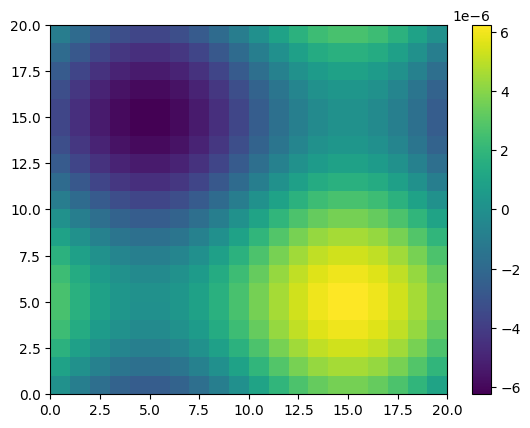

In [16]:
#plot the solution quantities

#enter the desired solution quantity here (displacements, stresses and strains):
quantity_to_plot = sigma_xy

z[x_i,y_i] = quantity_to_plot
#plot
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
im=ax.pcolormesh(z)
fig.colorbar(im,ax=ax)
plt.show()